Stock Price Prediction Project

Authors: Stefan Miller, John Mueller

Date: 4/21/2024

Description: Uses TwelveData's API to pull stock data based on desired parameters and uses machine learning models to provide a recommendation to buy, sell, or hold the desired stock.

Use this to install the TwelveData API Library in case it is not installed already

In [ ]:
pip install twelvedata[pandas,matplotlib,plotly]

This contains all necessary imports for this project, a variable for your API Key to be used to pull stock data from the API, and a variable used to store the path of the csv file.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from twelvedata import TDClient
import csv
import io

apikey="XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"
my_csv = "stock_data.csv"

This code retrieves stock data from the API and stores it in "stock_data.csv".  This is customizable, and is easy to change which stock you want data for, the time periods, how much data, and more.

In [ ]:
# Clear the csv file each time data is pulled so that there is only ever 1 set of data in the csv file at a time
f = open(my_csv, "w+")
f.close()

# Define the parameters for data collection
td = TDClient(apikey)
ts = td.time_series(
    symbol="TSLA",
    exchange="NASDAQ",
    interval="2h",
    start_date="2023-01-01",
    outputsize=5000,
    order="asc",
    timezone="America/New_York",
)

# Collect data using the above parameters for RSI, SMA, OHLCV
stock_data = ts.with_rsi().with_sma().with_stoch().as_csv()

# Output the collected data to a CSV file
with open(my_csv, 'w') as out:
  csv_out=csv.writer(out)
  csv_out.writerows(stock_data)

Next we make a correlation table to visualize what the indicators mean for the price of the stock.

Shape of the dataset: (1302, 9)
Description of the dataset:
                            datetime         open         high          low  \
count                           1302  1302.000000  1302.000000  1302.000000   
mean   2023-08-27 06:07:08.571428352   210.794205   212.695926   208.810047   
min              2023-01-03 09:30:00   103.000000   108.495000   101.810000   
25%              2023-05-01 12:00:00   180.515000   182.579925   178.920007   
50%              2023-08-25 14:30:00   207.000650   208.368150   204.750000   
75%              2023-12-21 13:00:00   246.760000   248.764972   244.440000   
max              2024-04-19 15:30:00   298.100010   299.290010   294.230010   
std                              NaN    40.233813    40.404418    39.984399   

             close        volume          rsi          sma       slow_k  
count  1302.000000  1.302000e+03  1302.000000  1302.000000  1302.000000  
mean    210.845095  3.127248e+07    50.376633   210.762579    51.488959  
min   

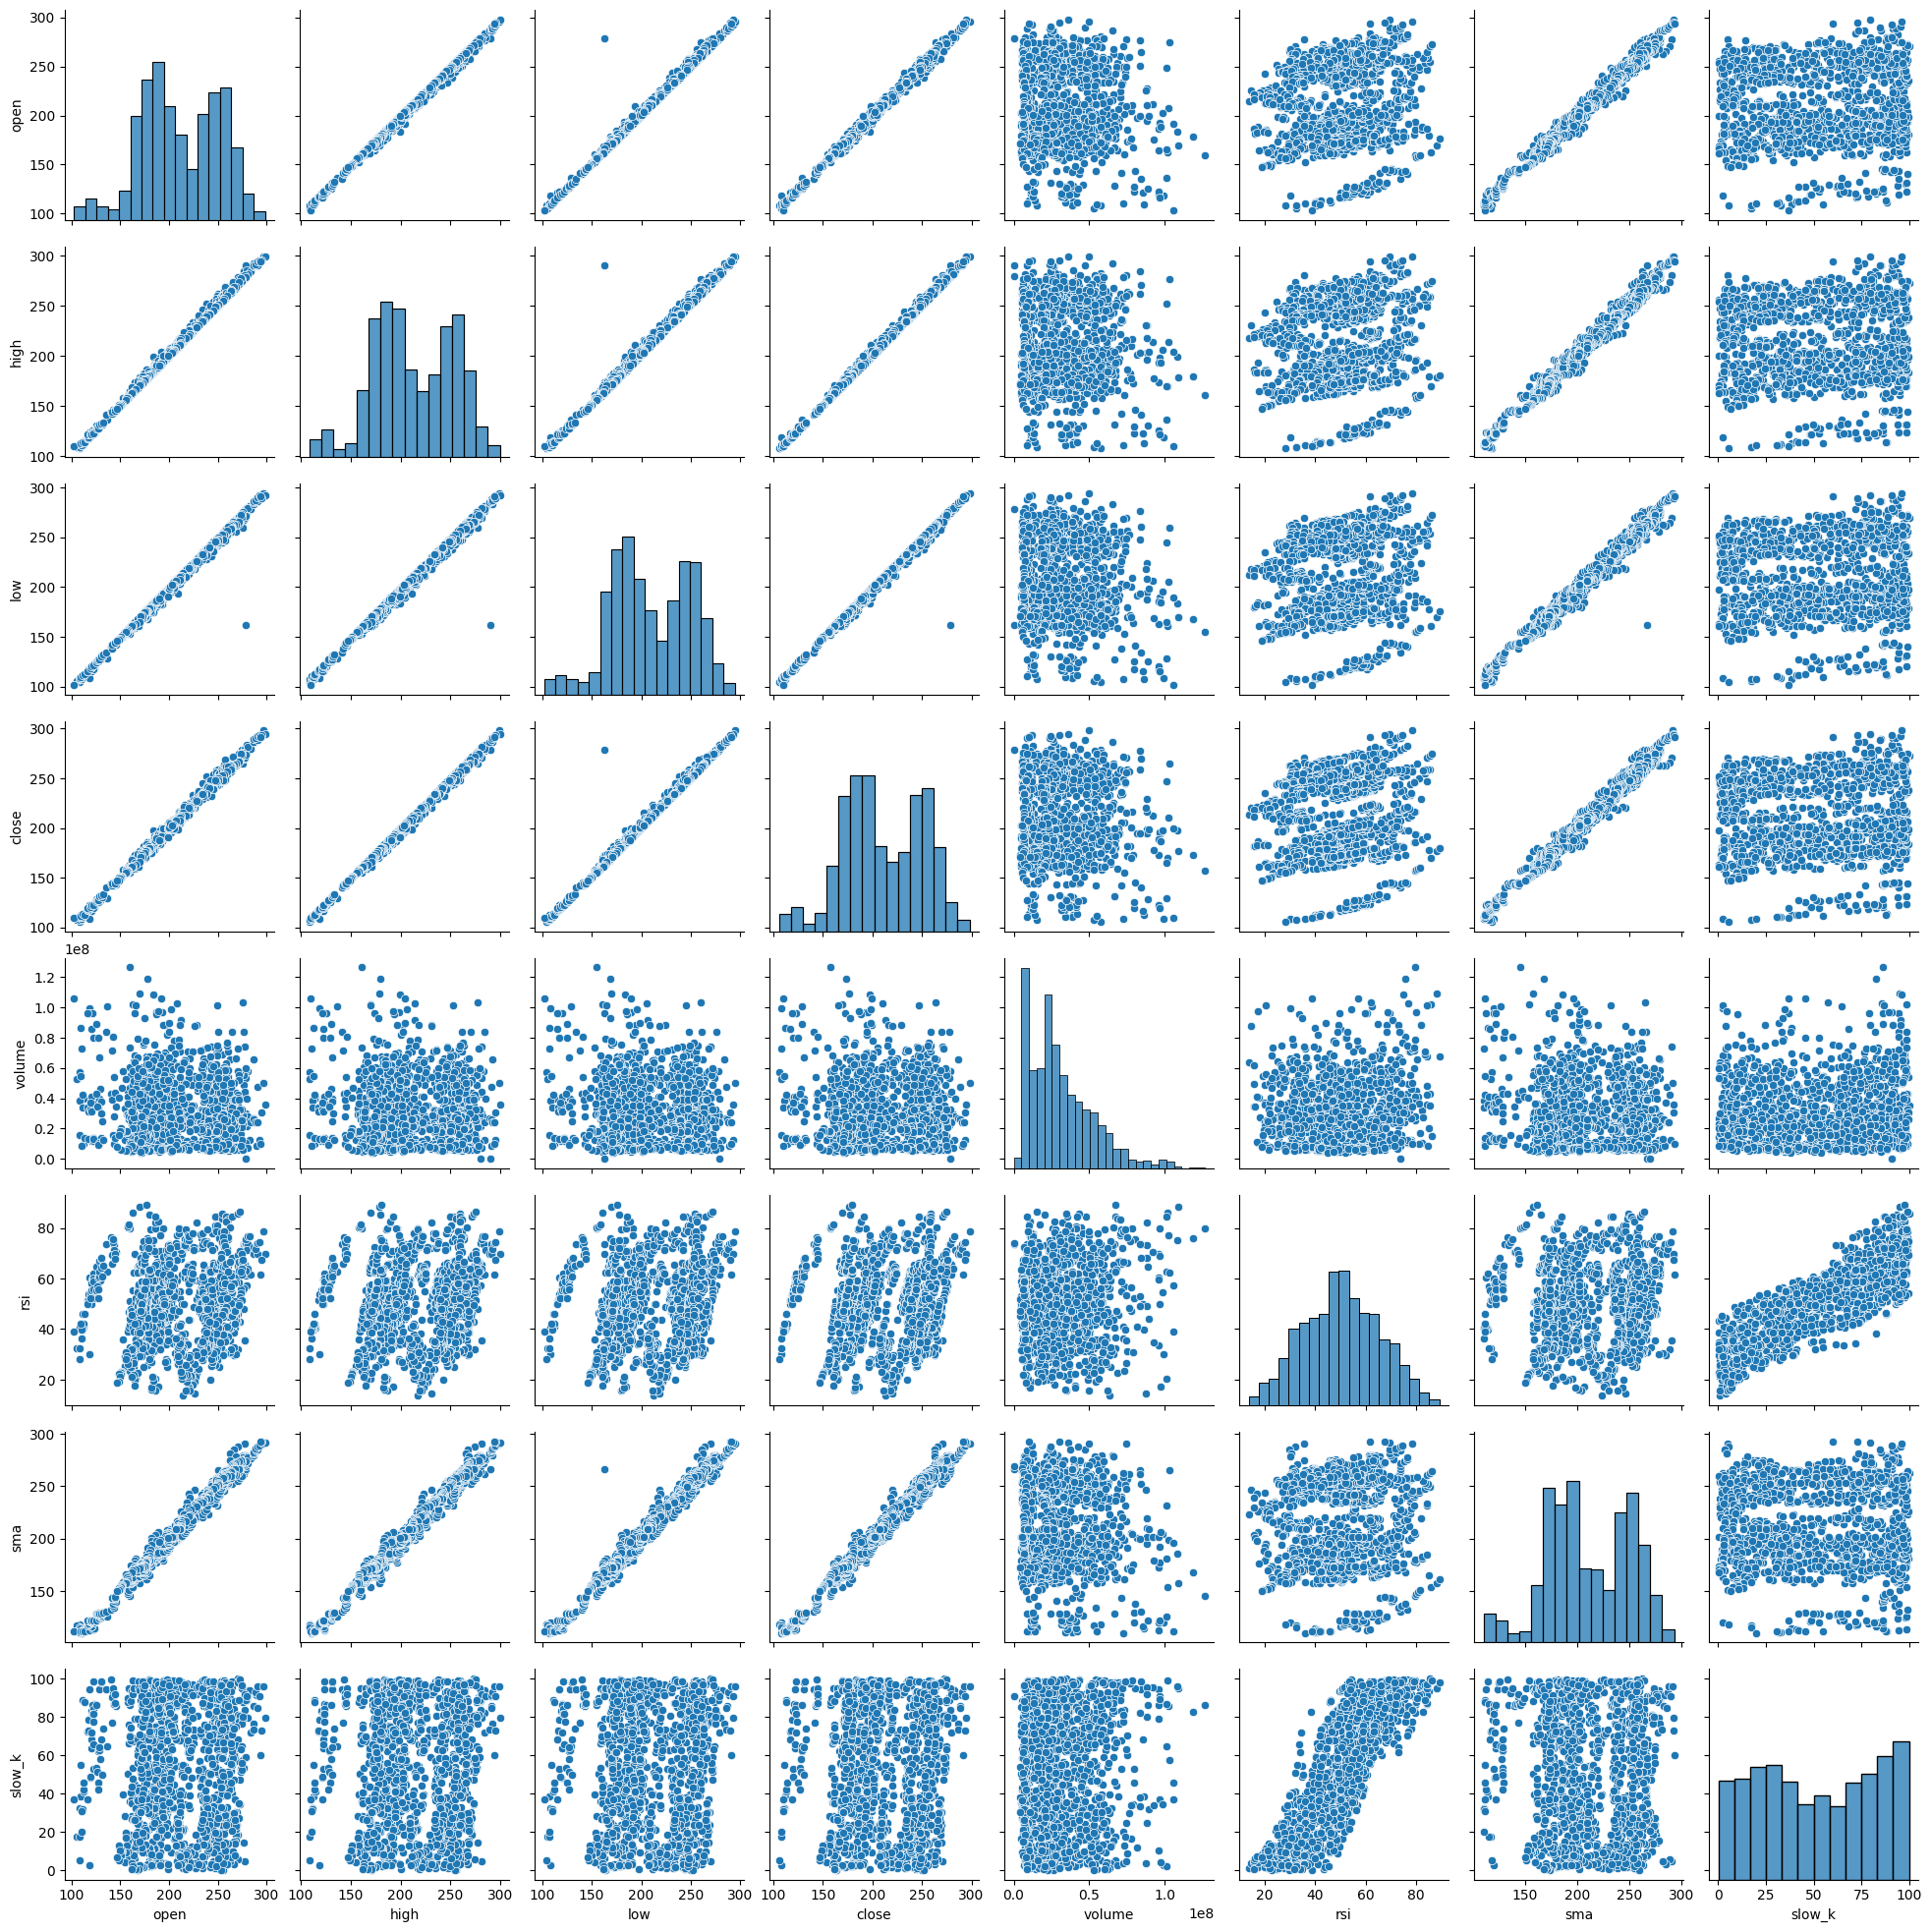

Correlation Matrix:
          datetime      open      high       low     close    volume  \
datetime  1.000000  0.193506  0.188632  0.197129  0.190896 -0.272862   
open      0.193506  1.000000  0.998818  0.995671  0.997820 -0.082806   
high      0.188632  0.998818  1.000000  0.994427  0.998831 -0.055922   
low       0.197129  0.995671  0.994427  1.000000  0.995774 -0.104342   
close     0.190896  0.997820  0.998831  0.995774  1.000000 -0.080652   
volume   -0.272862 -0.082806 -0.055922 -0.104342 -0.080652  1.000000   
rsi      -0.284959  0.150702  0.159260  0.154670  0.167737  0.116753   
sma       0.211247  0.992259  0.991622  0.988934  0.990759 -0.088252   
slow_k   -0.204756  0.084031  0.093732  0.091939  0.106019  0.064043   

               rsi       sma    slow_k  
datetime -0.284959  0.211247 -0.204756  
open      0.150702  0.992259  0.084031  
high      0.159260  0.991622  0.093732  
low       0.154670  0.988934  0.091939  
close     0.167737  0.990759  0.106019  
volume    0.1

In [ ]:
# Create a pandas dataframe of the collected data
df = pd.read_csv(my_csv)
df['datetime'] = pd.to_datetime(df['datetime'])

# Define target variable and features.  Target is the close price and features are everything else
X = df.iloc[:, :-1]
Y = df.iloc[:, 4]

# The following code was taken and modified from Homework Assignment 2

# Print the shape of the dataset
print("Shape of the dataset:", X.shape)
print("Description of the dataset:")
print(X.describe())

# Plot each data type relative to each other data type
sns.pairplot(X)
plt.show()

# Create a correlation matrix to determine which features have the largest effect on the closing price
correlation_matrix = X.corr()
print("Correlation Matrix:")
print(correlation_matrix)

Any necessary data manipulation goes here:

In [ ]:
# Split the data into training data and testing data
# Shuffle is set to false to keep the data in order
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=42)

# Convert the date and time data to unix time stamps for easier data handling
# Note: This section was made with the help of https://stackoverflow.com/questions/39207640/python-pandas-how-do-i-convert-from-datetime64ns-to-datetime
def convert_datetime(df):
  for col in df.columns:
    if df[col].dtype == "datetime64[ns]":
      df[col] = df[col].apply(lambda x: x.timestamp())
  return df

X_train = convert_datetime(X_train)
X_test = convert_datetime(X_test)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Next we run 3 regression models to determine which is the most fit for predicting if the price of a stock will increase or decrease.

Note: Portions of this code were taken and modified from Homework Assignment 5

In [ ]:
# Decision Tree:
decision_tree = DecisionTreeRegressor()

# Fit the model to the data and predict the next close price
decision_tree.fit(X_train_scaled, y_train)
y_pred_dt = decision_tree.predict(X_test_scaled)

# Cross validate the score to reduce overfitting
cv_scores_dt = cross_val_score(decision_tree, X_train_scaled, y_train, cv=5, scoring='r2')
mean_cv_r2_dt = cv_scores_dt.mean()

# Print the average R2 Score
print("Decision Tree R2 Score :", mean_cv_r2_dt)

Decision Tree R2 Score : 0.9268806016068043


In [ ]:
# Random Forest:
random_forest = RandomForestRegressor()

# Fit the model to the data and predict the next close price
random_forest.fit(X_train_scaled, y_train)
y_pred_rf = random_forest.predict(X_test_scaled)

# Cross validate the score to reduce overfitting
cv_scores_rf = cross_val_score(random_forest, X_train_scaled, y_train, cv=5, scoring='r2')
mean_cv_r2_rf = cv_scores_rf.mean()

# Print the average R2 Score
print("Random Forest R2 Score: ", mean_cv_r2_rf)

Random Forest R2 Score:  0.9259148222058606


In [ ]:
# K-Nearest Neighbors:
knn = KNeighborsRegressor()

# Fit the model to the data and predict the next close price
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Cross validate the score to reduce overfitting
cv_scores_knn = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='r2')
mean_cv_r2_knn = cv_scores_knn.mean()

# Print the average R2 Score
print("K-Nearest Neighbors R2 Score: ", mean_cv_r2_knn)

K-Nearest Neighbors R2 Score:  0.698781708799838


Selecting the best model

In [ ]:
print("The Regressor model with the highest R2 score is: ")

# Logic statements to determine which model has the best R2 Score
# Set "best_model" to the model with the highest R2 Score to be used later
if mean_cv_r2_dt > mean_cv_r2_rf and mean_cv_r2_dt > mean_cv_r2_knn:
  best_model = decision_tree
  print("Decision Tree")
elif mean_cv_r2_rf > mean_cv_r2_dt and mean_cv_r2_rf > mean_cv_r2_knn:
  best_model = random_forest
  print("Random Forest")
elif mean_cv_r2_knn > mean_cv_r2_rf and mean_cv_r2_knn > mean_cv_r2_dt:
  best_model = knn
  print("K-Nearest Neighbors")

The Regressor model with the highest R2 score is: 
Decision Tree


Predicting the closing price at the next interval

In [ ]:
# Get the most recent closing price of the stock
current_price = df['close'].iloc[-1]

# Predict the next closing price of the stock
predicted_price = best_model.predict(X_test_scaled[-1:])

# Display current and predicted prices
print("Current Price:", current_price)
print("Predicted Price:", predicted_price[0])

# Logic statements to determine if you should buy, sell, or hold the stock
if predicted_price > current_price * 1.01:  # Setting a 1% increase threshold
    print("Buy Signal: Predicted price is significantly higher than the current price.")
elif predicted_price < current_price * 0.99:  # Setting a 1% decrease threshold
    print("Sell Signal: Predicted price is significantly lower than the current price.")
else:
    print("Hold Signal: No significant change predicted.")

Current Price: 147.02
Predicted Price: 153.64
Buy Signal: Predicted price is significantly higher than the current price.
